# Backtesting the 'buying-the-dip' Trading Strategy

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /workspaces/data_ingestion/05_Yahoo_Finance_WebAPI


## Historical Data iShares Core MSCI World UCITS ETF

In [2]:
# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Load historical data iShares Core MSCI World UCITS ETF
ticker = 'IWDA.AS'
df = yf.download(ticker, 
                 start='2010-01-01', 
                 end=today, 
                 interval='1mo',
                 multi_level_index=False,
                 progress=False)


# Check currency
ticker = yf.Ticker("IWDA.AS")
print(f"The currency used by yfinance is: {ticker.info['currency']}")

# Monthly return
df['Monthly_Return'] = df['Close'].pct_change()
df

The currency used by yfinance is: EUR


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2010-01-01,17.940001,18.600000,17.770000,18.070000,14303,NaN
2010-02-01,18.379999,18.620001,17.139999,17.820000,86540,0.024526
2010-03-01,19.660000,19.930000,18.549999,18.559999,114226,0.069641
2010-04-01,20.090000,20.469999,19.770000,19.770000,7314,0.021872
2010-05-01,19.549999,20.415001,18.580000,20.070000,35831,-0.026879
...,...,...,...,...,...,...
2025-04-01,93.330002,98.550003,82.910004,98.000000,6419454,-0.039073
2025-05-01,99.275002,101.300003,93.330002,93.330002,2802259,0.063699
2025-06-01,100.144997,100.910004,98.035004,98.794998,1954341,0.008763


## Backtesting buying-the-dip versus fixed monthly investment Strategy

In [3]:
# Strategy 1: Invest a fixed amount every month
fixed_investment = 1000
df['Fixed Investment'] = fixed_investment
df['Fixed Shares'] = df['Fixed Investment'] / df['Close']
df['Fixed Total Shares'] = df['Fixed Shares'].cumsum()
df['Fixed Portfolio Value'] = df['Fixed Total Shares'] * df['Close']

# Strategy 2: Invest cumulative monthly savings after a drop of X%
threshold = 0.05
monthly_savings = 1000
df['Trigger Investment'] = 0.0
df['Trigger Shares'] = 0.0 
savings = 0.0

# Ensure that the index is a simple integer
df = df.reset_index()

for i in range(1, len(df)):
    if threshold == 0.00:
        # Invest fixed savings every month if the threshold is 0
        df.loc[i, 'Trigger Investment'] = monthly_savings
    else:
        # Accumulate savings if the threshold is > 0
        savings += monthly_savings
        # Invest the accumulated savings if the price drops by at least threshold
        if df.loc[i, 'Close'] <= df.loc[i-1, 'Close'] * (1 - threshold):
            df.loc[i, 'Trigger Investment'] = savings
            savings = 0

    # Calculate the number of shares bought
    df.loc[i, 'Trigger Shares'] = (
        df.loc[i, 'Trigger Investment'] / df.loc[i, 'Close']
    )

# Calculate the total number of shares and the portfolio value
df['Trigger Total Shares'] = df['Trigger Shares'].cumsum()
df['Trigger Portfolio Value'] = df['Trigger Total Shares'] * df['Close']

# Output the final portfolio values
print(f"Final portfolio value with fixed monthly investment: {df['Fixed Portfolio Value'].iloc[-1]:.2f} EUR")
print(f"Final portfolio value with investment after a drop: {df['Trigger Portfolio Value'].iloc[-1]:.2f} EUR")

# Difference in portfolio values
diff = df['Trigger Portfolio Value'].iloc[-1] - df['Fixed Portfolio Value'].iloc[-1]
print(f"\nDifference in portfolio values: {diff:.2f} EUR")

Final portfolio value with fixed monthly investment: 515018.79 EUR
Final portfolio value with investment after a drop: 451567.40 EUR

Difference in portfolio values: -63451.39 EUR


## Plot the results

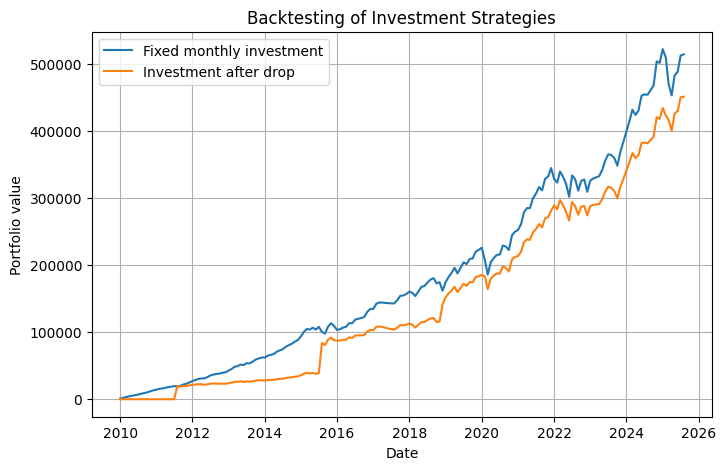

In [4]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(df['Date'], df['Fixed Portfolio Value'], label='Fixed monthly investment')
plt.plot(df['Date'], df['Trigger Portfolio Value'], label='Investment after drop')
plt.title('Backtesting of Investment Strategies')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.legend()
plt.grid(True)
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [5]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-08-25 15:45:47
Python Version: 3.11.13
-----------------------------------
